## Margin Modeling

### Importing packages

In [10]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, f_regression


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

## Import modeling data created in the Data Prep pipeline.

In [2]:
import os
os.chdir("D:\Sunny_Personal\OSU MSBA\Fall 2019\BAN5561_CLV")
combined_df = pd.read_csv('combined_data.csv')
combined_df.shape

(73384, 111)

## Using the head method to preview our data:

In [3]:
combined_df.head()

,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,tier,tier_prev,acct_ID,activation_date,event_date,churn_year_plus1_ind,log_order_cnt_36mo,log_purch_amt_36mo,log_purch_amt_life,log_purch_avg_36mo,...,ST_RI,ST_SC,ST_SD,ST_TN,ST_TX,ST_UT,ST_VA,ST_VI,ST_VT,ST_WA,ST_WI,ST_WV,ST_WY,ST_missing,tier_1-Bronze,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_1-Bronze,tier_prev_2-Silver,tier_prev_3-Gold,tier_prev_4-Platinum,tier_prev_5-Diamond,tier_prev_xxx
0,VA,23464,544,missing,0,0,1,0,0,2,128,2.93,4,0,0,3-Gold,xxx,B102465045,04JAN04,30JUN15,1,0.30,4.16,4.42,2.54,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,NC,27542,560,919,1,1,1,0,0,4,122,2.11,22,4,0,5-Diamond,3-Gold,B106897643,04JUL04,NaN,0,0.95,3.50,4.09,2.14,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,NV,89109,839,702,0,0,1,0,0,8,96,88.00,1,0,0,1-Bronze,xxx,B111832829,03SEP06,NaN,0,0.30,2.48,3.03,2.48,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,OH,43050,535,614,0,1,1,0,0,1,108,1.02,36,0,0,1-Bronze,xxx,B112883062,03SEP05,NaN,0,0.85,2.85,3.33,1.32,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,HI,96789,744,808,1,1,1,0,0,4,105,1.53,19,4,0,4-Platinum,3-Gold,B113581008,03DEC05,NaN,0,0.85,3.93,4.30,2.65,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


## Printing variable stats:

In [4]:
print(" summary stats on combined data ") 
"""print(combined_df.describe(include='all').transpose())"""
# describe only the numeric variables:
print(combined_df.describe(include = [np.number]).transpose())

 summary stats on combined data 
                            count      mean       std       min    25%     50%     75%        max
emailable                 73384.0  5.18e-01  5.00e-01      0.00   0.00    1.00    1.00       1.00
solicit_ph_ind            73384.0  8.92e-01  3.11e-01      0.00   1.00    1.00    1.00       1.00
solicit_email_ind         73384.0  9.64e-01  1.87e-01      0.00   1.00    1.00    1.00       1.00
fixd_incm_flg             73384.0  9.19e-02  2.89e-01      0.00   0.00    0.00    0.00       1.00
scheduled_purchase_flg    73384.0  2.65e-01  4.41e-01      0.00   0.00    0.00    1.00       1.00
months_since_last_trans   73384.0  2.91e+00  3.10e+00      1.00   1.00    1.00    4.00      12.00
months_since_first_trans  73384.0  6.53e+01  5.81e+01      1.00  14.00   46.00  109.00     298.00
purch_avg_interval        73384.0  4.85e+00  9.95e+00      0.00   1.00    1.21    2.56     165.00
mail_cnt_36mo             73384.0  1.91e+01  1.48e+01      0.00   6.00   16.00   33.0

###  Exploratory Data Analysis

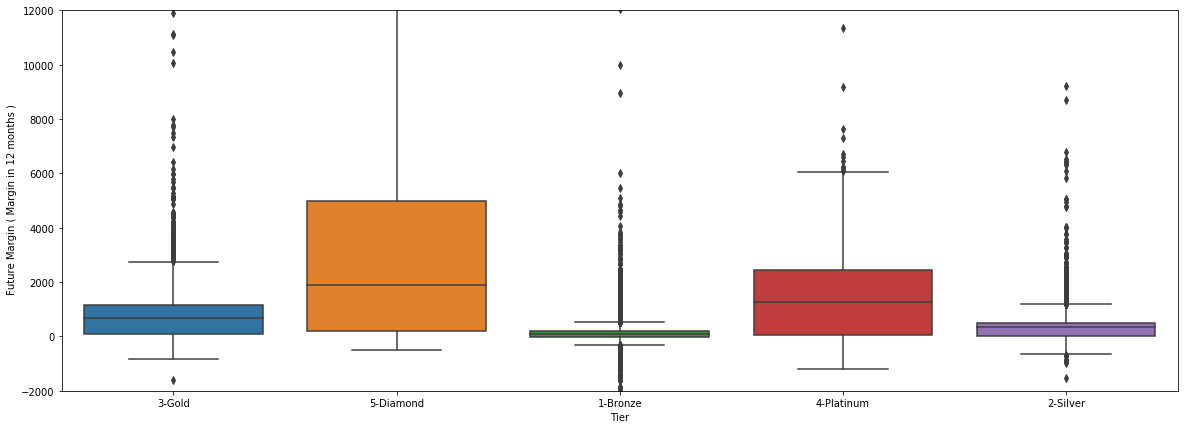

In [26]:
#Visualizing the target(future margin) against the tiers
plt.figure(figsize=(20,7))
axes=sns.boxplot(y='margin_Y_pos_1', x='tier',data=combined_df)
# given the extreme values/range for future margin, limiting the range of the y-axis:
axes.set(ylim=(-2000, 12000))    
plt.xlabel('Tier')
plt.ylabel(' Future Margin ( Margin in 12 months )')
plt.show()

### Dropping variables we don't want to included in modeling

In [27]:
x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date','ST','tier','tier_prev'],axis=1)
x_train_df.shape

(73384, 103)

        For churners, there is no future margin associated with it.
        We are going to eliminate the records associated with the "churners".
        

In [28]:
#first we keep the churners, to score them later 
x_churners_df = x_train_df.query('churn_year_plus1_ind==1')

#then we strip our the churners from the data to be used for training and testing
x_train_df = x_train_df.query('churn_year_plus1_ind==0')

x_train_df.shape

(54078, 103)

### Partitioning data into Training and Test sets

In [29]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30)

# will need the acct_IDs to rejoin data later,
#so pulling out now before dropping from actual model training data 

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]
churners_acct_IDs_df = x_churners_df[['acct_ID']]


y_train_df = x_train_df[['log_margin_Y_pos_1']]
y_test_df  = x_test_df[['log_margin_Y_pos_1']]
y_churners_df  = x_churners_df[['log_margin_Y_pos_1']]

# we want to drop acct_ID and the target variable from the dataframe of independent variables 
# we want to drop the target (future timeframe) variables for churn modeling                

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'],axis=1)
x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'],axis=1)

x_churners_df = x_churners_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'],axis=1)

x_train_df.shape

(37854, 99)

### Using the SelectKBest and f_regression to select K parameters with highest f-values.
### We'll use this as a preliminary non-machine-learning approach.

In [30]:
#using the ravel simply to avoid warning in log 
y_train_array=np.ravel(y_train_df)
y_test_array=np.ravel(y_test_df)

# This line can be used to suppress any warnings caused by missing values:
"""np.seterr(divide='ignore', invalid='ignore')"""

model1_selects = SelectKBest(f_regression, k=20).fit(x_train_df, y_train_array)

x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]

# """note: we are not reducing the columns in the held-out churners dataframe, 
# because this is not our final model"""

x_train_selected_df.shape

(37854, 20)

## Introducing variable reduction that addresses multicolinearity:

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
        else:
            dropped=False
    print('Remaining variables:')
    print(X.columns[variables])        
        
    return X.iloc[:, variables]

# to drop fewer variables, and allow more multicollinearity, increase the numeric threshold here.
#    10 is a good default.  try 15 or 20 to omit fewer variables
x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

C:\Users\Harish Patlolla\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'margin_Y_neg_1' at index: 5
dropping 'log_margin_3yr_avg' at index: 11
dropping 'log_margin_Y_neg_2' at index: 9
dropping 'log_margin_Y_neg_1' at index: 8
dropping 'log_purch_amt_36mo' at index: 2
dropping 'log_margin_Y_neg_3' at index: 7
dropping 'log_purch_amt_life' at index: 2
dropping 'margin_3yr_avg' at index: 5
Remaining variables:
Index(['mail_cnt_36mo', 'call_out_mo_36mo', 'log_purch_avg_36mo', 'margin_Y_neg_2', 'margin_Y_neg_3', 'tier_1-Bronze', 'tier_4-Platinum', 'tier_5-Diamond', 'tier_prev_3-Gold', 'tier_prev_4-Platinum', 'tier_prev_5-Diamond', 'tier_prev_xxx'], dtype='object')


(37854, 12)

## Reducing test set to match training set selected variables:

In [32]:
""" reducing the test set to have the same columns as the training set """
""" note: we are not reducing the columns in the held-out churners dataframe, because this is not our final model """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]

print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['mail_cnt_36mo', 'call_out_mo_36mo', 'log_purch_avg_36mo', 'margin_Y_neg_2', 'margin_Y_neg_3', 'tier_1-Bronze', 'tier_4-Platinum', 'tier_5-Diamond', 'tier_prev_3-Gold', 'tier_prev_4-Platinum', 'tier_prev_5-Diamond', 'tier_prev_xxx'], dtype='object')


(16224, 12)

## Using the statsmodels package to see "friendlier" looking Regression output:

C:\Users\Harish Patlolla\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


 
OLS model with selected variables
 
                            OLS Regression Results                            
Dep. Variable:     log_margin_Y_pos_1   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     3808.
Date:                Fri, 03 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:45:14   Log-Likelihood:             1.3095e+05
No. Observations:               37854   AIC:                        -2.619e+05
Df Residuals:                   37841   BIC:                        -2.618e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

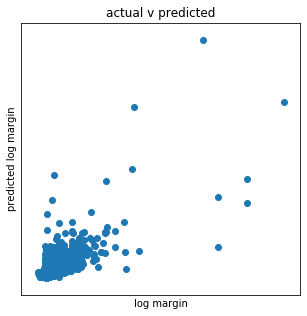

In [33]:
""" for the statsmodels, need to add a constant to fit intercept """
""" the add_constant function won't add a constant if there's already a variable with variance=0 """
"""     unless the has_constant option is added """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" warning:  the OLS here is case-sensitive """
model = sm.OLS(y_train_df, x_train_selected_df)
result = model.fit()
print(" ") 
print("OLS model with selected variables")
print(" ") 
print(result.summary())

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train:", mean_squared_error(y_train_array, predict_train))
print("MSE test:", mean_squared_error(y_test_array, predict_test))

plt.figure(figsize=(5,5))
plt.scatter(y_train_array, predict_train)
plt.xlabel("log margin")
plt.ylabel("predicted log margin")
plt.title ("actual v predicted")
plt.xticks([])
plt.yticks([])
print(" ") 
plt.show()

### Gra

GB overall accuracy, for model with all variables: 0.5915134451704828
 
MSE train, for model with all variables: 1.0841605064702018e-05
MSE test, for model with all variables: 4.095502319757707e-05


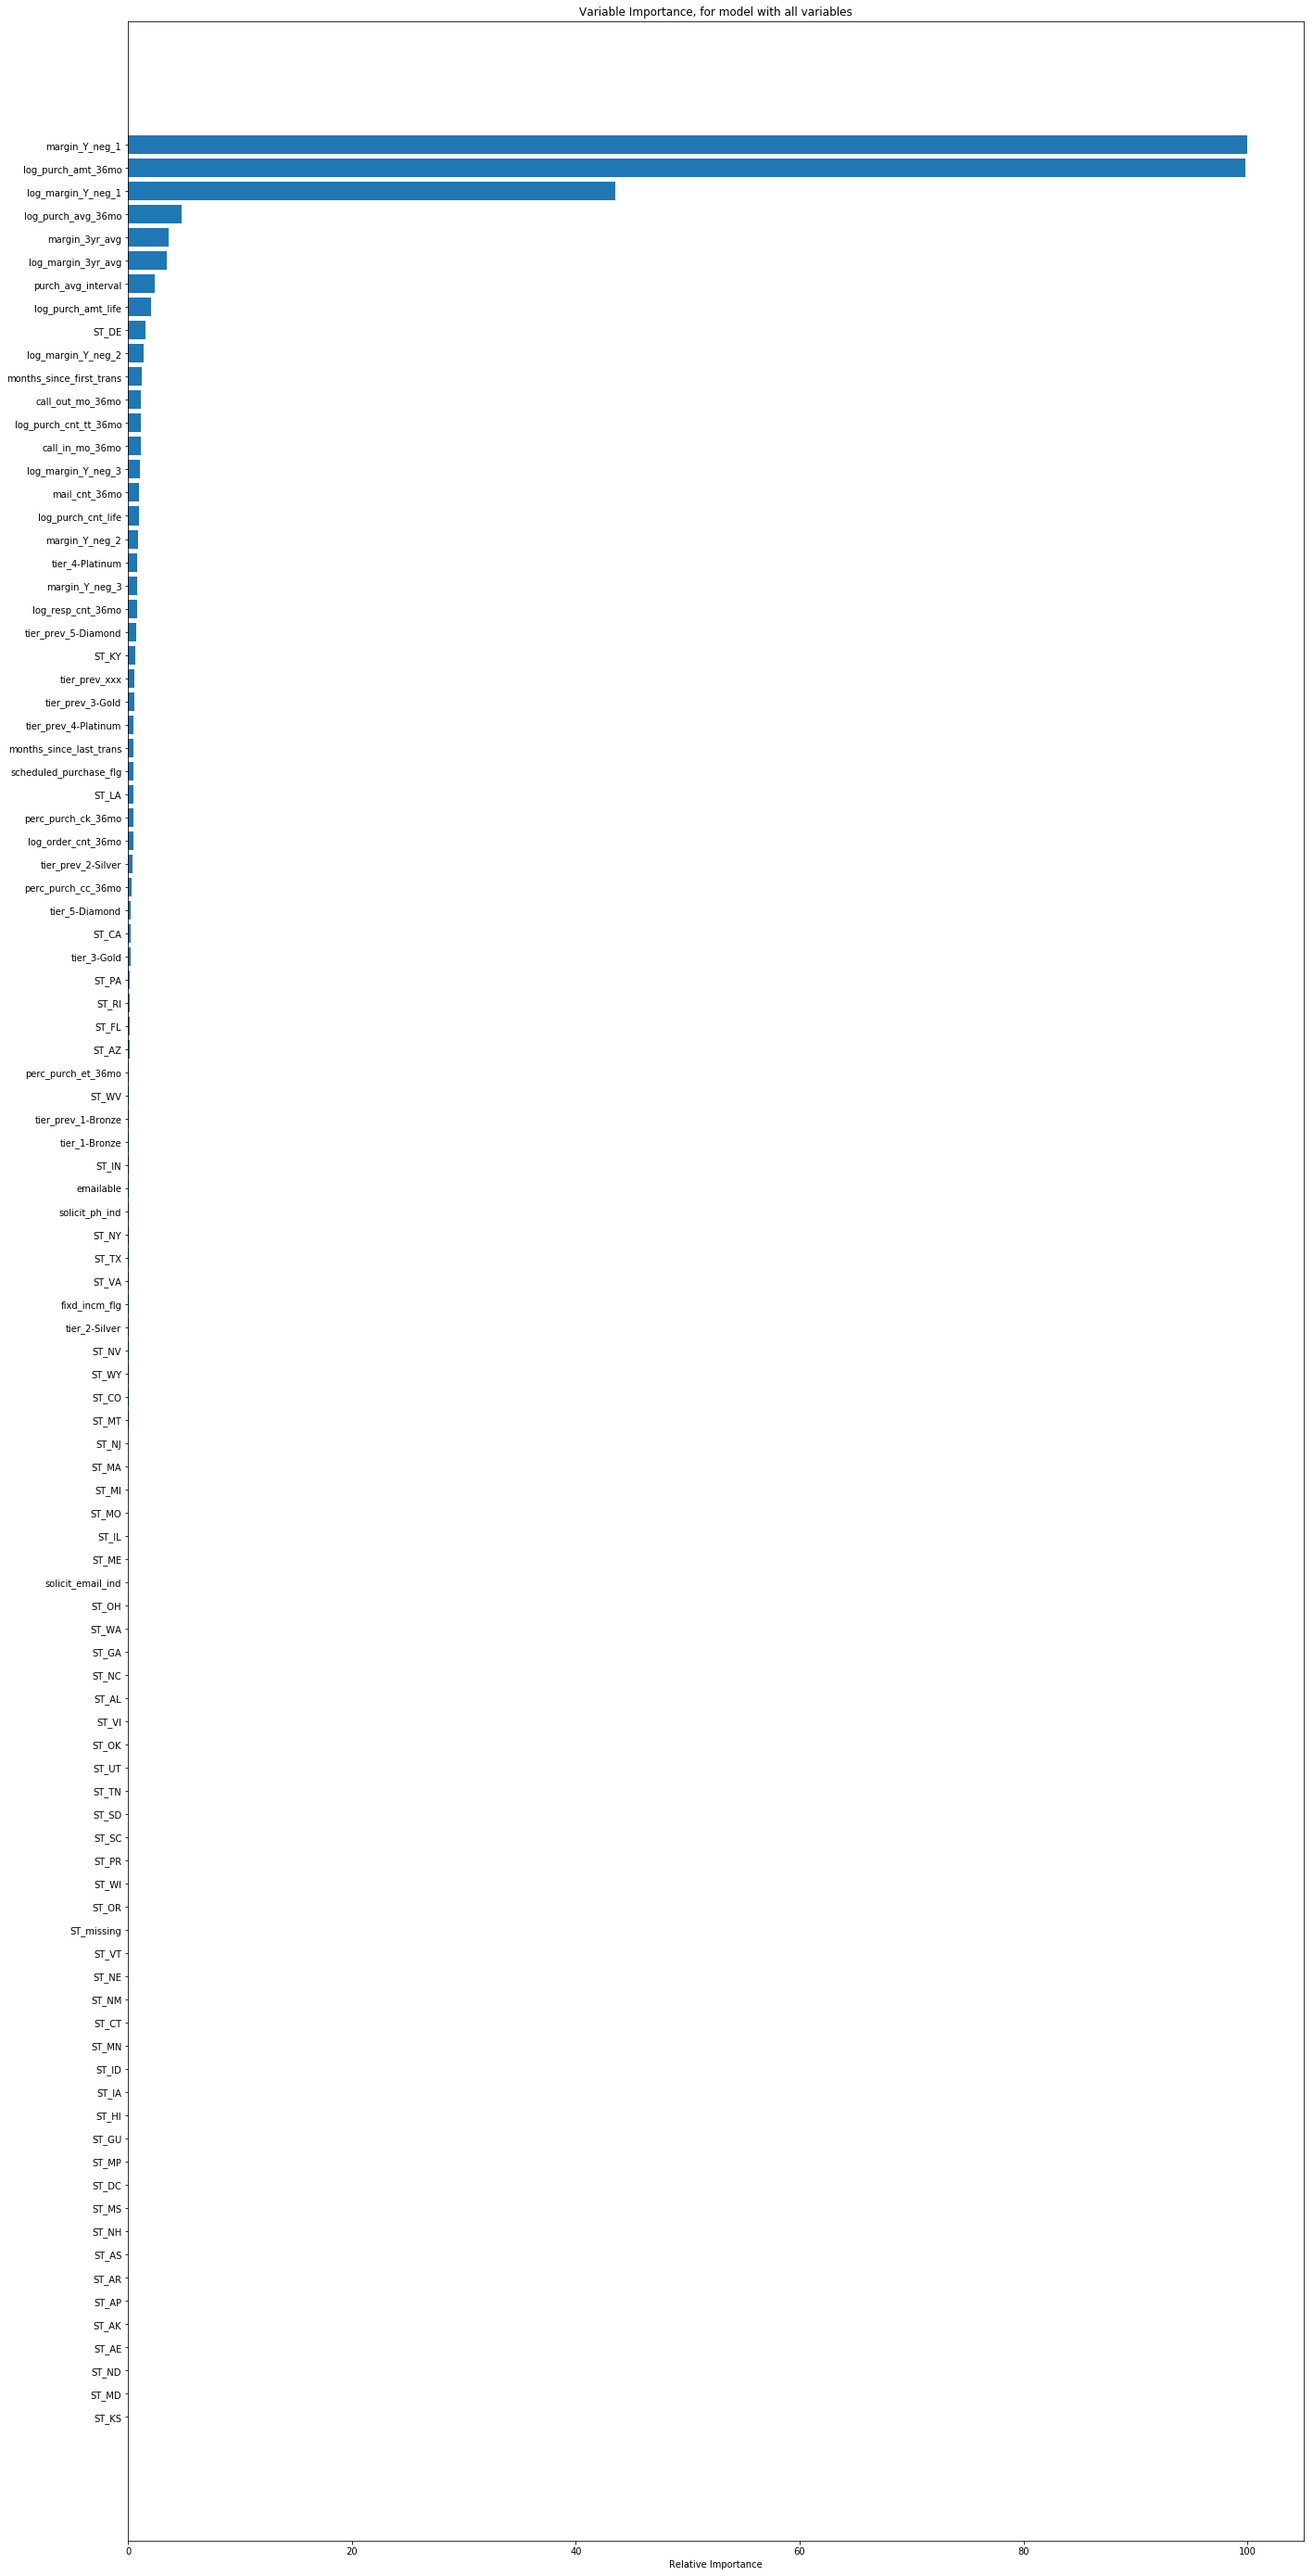

GB overall accuracy, for model with only selected features: 0.5505161236089169
 
MSE train, for model with only selected features: 1.4488291144375052e-05
MSE test, for model with only selected features: 4.506543083704812e-05


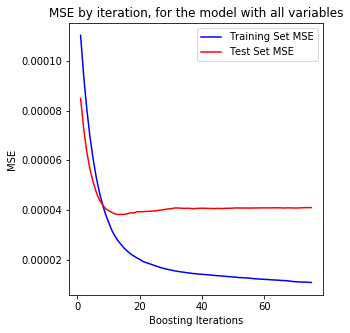

In [35]:
""" Gradient Boosting """
params = {'n_estimators': 75, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.1, 'loss': 'ls'}

model7 = GradientBoostingRegressor(**params)

""" switch the order of X and Y for the fit to work with GradientBoosting """
""" also, note that we are starting with the full training data, and not the selected variables from above """
result = model7.fit(x_train_df, y_train_array)

""" returns mean accuracy"""
accuracy = model7.score(x_test_df, y_test_df)
print("GB overall accuracy, for model with all variables:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model7.predict(x_train_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(model7.predict(x_test_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train, for model with all variables:", mean_squared_error(y_train_array, predict_train))
print("MSE test, for model with all variables:", mean_squared_error(y_test_array, predict_test))

# Plot feature importance
feature_importance = result.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance, for model with all variables')
plt.show()

""" plotting MSE with each iteration for the model with all variables """

test_MSE  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_MSE = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model7.staged_predict(x_test_df)):
    test_MSE[i] = mean_squared_error(y_test_array, y_pred)

for i, y_pred in enumerate(model7.staged_predict(x_train_df)):
    train_MSE[i] = mean_squared_error(y_train_array, y_pred)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('MSE by iteration, for the model with all variables')
plt.plot(np.arange(params['n_estimators']) + 1, train_MSE, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_MSE, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')

""" select only impactful features """
""" note:  decrease/increase this threshold (a relative number between 0 and 100) to select more/less features """
selected_features = (feature_importance > 10)

""" creating a dataframe of independent variables, from the training (and test) data """
"""     having only those independent variables selected above """

x_train_selected_df = x_train_df[x_train_df.columns[selected_features]]
x_test_selected_df = x_test_df[x_test_df.columns[selected_features]]

""" we are also reducing columns in churners data, as this is our final model """
"""     and any data we want to score needs to have the correct columns """
x_churners_selected_df = x_churners_df[x_churners_df.columns[selected_features]]

""" refitting the model using a subset of features """
""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model7.fit(x_train_selected_df, y_train_array)
""" returns mean accuracy"""
accuracy = model7.score(x_test_selected_df, y_test_df)
print("GB overall accuracy, for model with only selected features:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model7.predict(x_train_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(model7.predict(x_test_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_churners = pd.DataFrame(np.copy(model7.predict(x_churners_selected_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train, for model with only selected features:", mean_squared_error(y_train_array, predict_train))
print("MSE test, for model with only selected features:", mean_squared_error(y_test_array, predict_test))


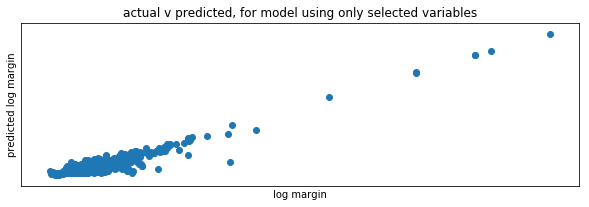

Text(0,0.5,'MSE')

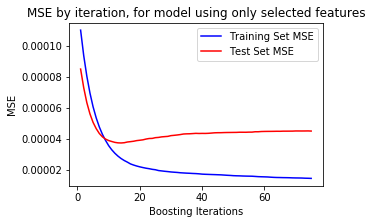

In [41]:

plt.figure(figsize=(10,3))
plt.scatter(y_train_array, predict_train)
plt.xlabel("log margin")
plt.ylabel("predicted log margin")
plt.title("actual v predicted, for model using only selected variables")
plt.xticks([])
plt.yticks([])
print(" ") 
plt.show()

""" plotting MSE with each iteration """

test_MSE  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_MSE = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model7.staged_predict(x_test_selected_df)):
    test_MSE[i] = mean_squared_error(y_test_array, y_pred)

for i, y_pred in enumerate(model7.staged_predict(x_train_selected_df)):
    train_MSE[i] = mean_squared_error(y_train_array, y_pred)

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.title('MSE by iteration, for model using only selected features')
plt.plot(np.arange(params['n_estimators']) + 1, train_MSE, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_MSE, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')

## Feature Importance for the Gradient Boosting Model:

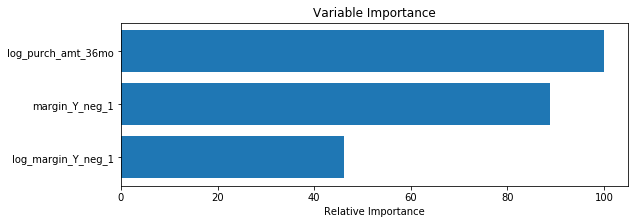

In [42]:
feature_importance = model7.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,3))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Appending the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [43]:
""" append together train and test predicted values, keeping only acct ID and predicted values """
""" also predicting values for the held-out churners and appending those, so we have all rows """

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)
y_churners_df = y_churners_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

churners_accounts = churners_acct_IDs_df.reset_index(drop=True)
pred_v_actual_churners = y_churners_df.join(predict_churners)
pred_v_actual_churners = pred_v_actual_churners.join(churners_accounts)

""" appending test to train, and calling it train """
pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_test, ignore_index=True)
""" appending churners to train, and calling it train """
pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_churners, ignore_index=True)

""" dropping the actuals and keeping just the predicted values """
pred_v_actual_train = pred_v_actual_train.drop(['log_margin_Y_pos_1'
                             ],axis=1)

""" and then save predicted values by acct ID to csv """

pred_v_actual_train.to_csv('margin_scores.csv',index=False)
pred_v_actual_train.shape

(73384, 2)

## (back to lecture mode)